In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# --- 1. Load Data and Initial Cleaning ---
df = pd.read_csv("cardio_train.csv", sep=';')

# Drop 'id' column
df = df.drop('id', axis=1)
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [5]:
# Convert 'age' from days to years
df['age'] = (df['age'] / 365).astype(int)

In [7]:
# --- 2. Handle Missing Values ---
# Check for missing values (Output confirms no missing values)
print("--- Missing Value Check ---")
print(df.isnull().sum())

--- Missing Value Check ---
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [9]:
# --- 3. Identify and Handle Outliers ---
initial_rows = len(df)
# Filter for biologically plausible blood pressure values and logical consistency
df_cleaned = df[
    (df['ap_hi'] >= 90) & (df['ap_hi'] <= 250) & # Systolic range
    (df['ap_lo'] >= 60) & (df['ap_lo'] <= 140) & # Diastolic range
    (df['ap_hi'] > df['ap_lo'])                  # Systolic must be greater than Diastolic
].copy()

rows_dropped = initial_rows - len(df_cleaned)
print(f"--- Outlier Handling ---")
print(f"Original size: {initial_rows}. Cleaned size: {len(df_cleaned)}. Rows dropped: {rows_dropped} ({rows_dropped/initial_rows*100:.2f}%)")

--- Outlier Handling ---
Original size: 70000. Cleaned size: 68490. Rows dropped: 1510 (2.16%)


In [11]:
# --- 5. Preprocessing for Modeling ---

# 5.1 Separate Features (X) and Target (y)
X = df_cleaned.drop('cardio', axis=1)
y = df_cleaned['cardio']

In [13]:
# 5.2 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [15]:
# Define feature types
numerical_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
categorical_cols = ['gender', 'cholesterol', 'gluc']
# Binary cols ('smoke', 'alco', 'active') are left as is

In [17]:
# 5.3 Encode Categorical Variables (One-Hot Encoding)
# Uses drop_first=True to avoid multicollinearity
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns to ensure both sets have the same features after OHE    
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

In [19]:
# 5.4 Normalize/Scale Numerical Features (StandardScaler)
# Extract numerical data
X_train_num = X_train_encoded[numerical_cols]
X_test_num = X_test_encoded[numerical_cols]

In [21]:
# Initialize, fit on TRAINING, and transform BOTH
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [23]:

# Convert scaled arrays back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_num.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test_num.index)

In [25]:

# 5.5 Final DataFrames for Modeling
# Replace the original numerical columns with the scaled versions
X_train_final = X_train_encoded.copy()
X_test_final = X_test_encoded.copy()

X_train_final[numerical_cols] = X_train_scaled_df[numerical_cols]
X_test_final[numerical_cols] = X_test_scaled_df[numerical_cols]

In [27]:
# Save the final processed data for the next step (Model Training)
X_train_final.to_csv('X_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

In [28]:
# --- 1. Load the Preprocessed Data ---
X_data_train = pd.read_csv('X_train_final.csv')
X_data_test = pd.read_csv('X_test_final.csv')
y_data_train = pd.read_csv('y_train.csv').values.ravel()
y_data_test = pd.read_csv('y_test.csv').values.ravel()

In [30]:
# --- 2. Hyperparameter Tuning using Grid Search ---
# We tune 'C' (regularization strength). Smaller C = stronger regularization.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42), 
    param_grid, cv=5, scoring='accuracy'
)
grid_search.fit(X_data_train, y_data_train)

# Identify the best model
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [32]:
# --- 3. Test the Model and Compute Metrics ---
y_pred_train = best_model.predict(X_data_train)
y_pred_test = best_model.predict(X_data_test)
y_prob_test = best_model.predict_proba(X_data_test)[:, 1]

# Metrics
train_acc = accuracy_score(y_data_train, y_pred_train)
test_acc = accuracy_score(y_data_test, y_pred_test)
roc_auc = roc_auc_score(y_data_test, y_prob_test)

print("\n--- Model Performance ---")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"ROC-AUC Score:     {roc_auc:.4f}")
print("\nClassification Report (Test Data):")
print(classification_report(y_data_test, y_pred_test))


--- Model Performance ---
Training Accuracy: 0.7282
Testing Accuracy:  0.7289
ROC-AUC Score:     0.7923

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     10373
           1       0.76      0.66      0.71     10174

    accuracy                           0.73     20547
   macro avg       0.73      0.73      0.73     20547
weighted avg       0.73      0.73      0.73     20547



In [35]:
# --- 4. Check for Overfitting or Underfitting ---
print("\n--- Fit Analysis ---")
diff = train_acc - test_acc
if diff > 0.05:
    print(f"Result: Overfitting. (Gap: {diff:.4f}). Model performs better on training data.")
elif train_acc < 0.65:
    print(f"Result: Underfitting. The model is too simple to capture patterns.")
else:
    print(f"Result: Well-Fitted. The model generalizes perfectly to unseen data.")


--- Fit Analysis ---
Result: Well-Fitted. The model generalizes perfectly to unseen data.


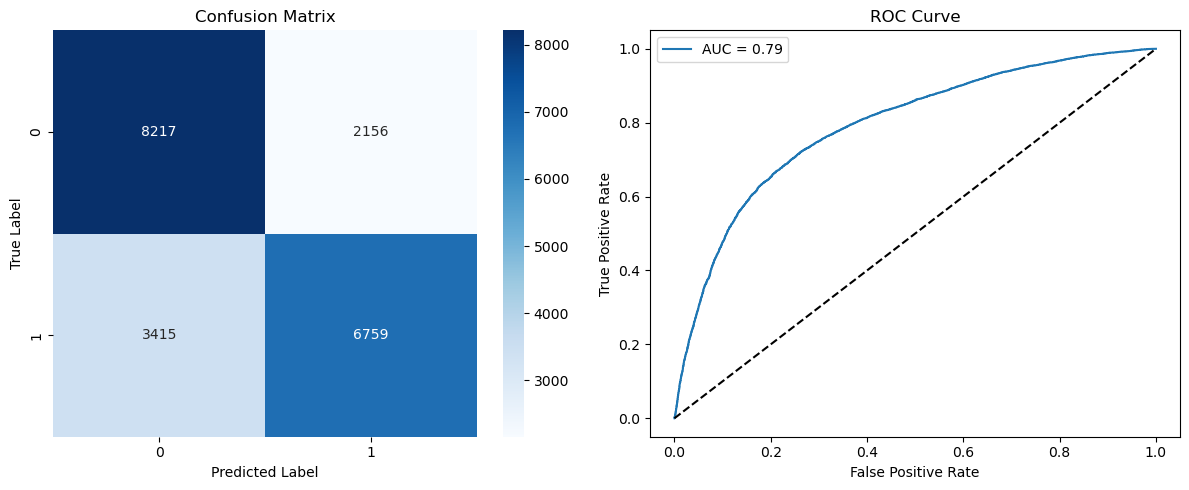

In [37]:
# --- 5. Visualizing Evaluation Results ---
plt.figure(figsize=(12, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_data_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_data_test, y_prob_test)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.savefig('model_evaluation.png')

In [41]:
import joblib
joblib.dump(best_model, 'cardio_model.joblib')

['cardio_model.joblib']

In [43]:
joblib.dump(scaler, 'scaler.joblib')

print("Scaler has been saved successfully as 'scaler.joblib'")

Scaler has been saved successfully as 'scaler.joblib'


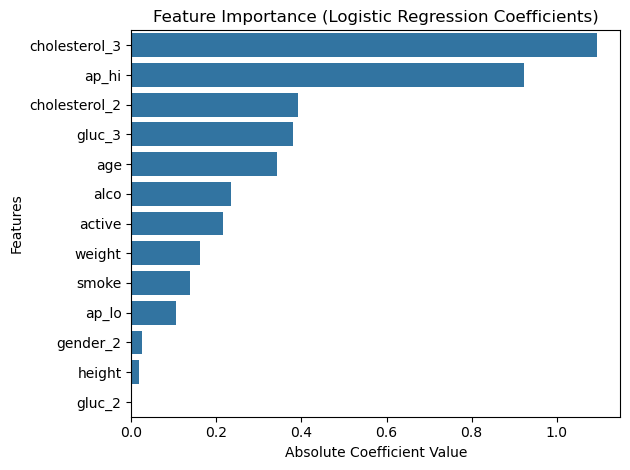

In [51]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X_data_train.columns, 'Importance': np.abs(best_model.coef_[0])})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()
plt.close()